# 價差策略 pair trading
* 作者 江祐宏
* 改良 TMBA 程式交易部的講義
* 2021/7/5

In [1]:
# 資料夾相對路徑
import os
path = os.getcwd()

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader as web
plt.style.use('seaborn')

## 1. 資料分析

### 1.0 取得資料

In [3]:
code_list = ['2303.TW', '2317.TW', '2330.TW', '2337.TW', '2454.TW']
close_df = pd.read_csv(path+'/dataset/TW150_CloseAdj.csv', parse_dates=True, index_col='Date').loc['2010-01-04':][code_list]
close_df

,2303.TW,2317.TW,2330.TW,2337.TW,2454.TW
Date,,,,,
2010-01-04,10.645722,71.586014,43.837044,26.497847,361.642090
2010-01-05,10.770967,72.058533,43.566853,26.203426,362.280243
2010-01-06,11.522430,71.586014,43.837044,26.350639,366.744476
2010-01-07,11.522430,70.877258,43.364216,25.982613,357.815399
2010-01-08,11.397185,71.113503,43.229134,25.835400,350.799591
...,...,...,...,...,...
2020-12-25,46.750000,91.800003,511.000000,40.400002,715.000000
2020-12-28,48.599998,91.800003,515.000000,43.799999,740.000000
2020-12-29,47.400002,90.400002,515.000000,41.849998,734.000000


### 1.1 相關係數矩陣與熱力圖

In [4]:
close_df.corr(method='pearson')

,2303.TW,2317.TW,2330.TW,2337.TW,2454.TW
2303.TW,1.000000,0.318111,0.812400,0.483585,0.764609
2317.TW,0.318111,1.000000,0.496160,0.333008,0.120090
2330.TW,0.812400,0.496160,1.000000,0.443051,0.638378
2337.TW,0.483585,0.333008,0.443051,1.000000,0.378741
2454.TW,0.764609,0.120090,0.638378,0.378741,1.000000


In [5]:
close_df.corr(method='kendall')

,2303.TW,2317.TW,2330.TW,2337.TW,2454.TW
2303.TW,1.000000,0.456213,0.575615,0.342270,0.326293
2317.TW,0.456213,1.000000,0.477845,0.110050,0.135949
2330.TW,0.575615,0.477845,1.000000,0.067509,0.198224
2337.TW,0.342270,0.110050,0.067509,1.000000,0.236496
2454.TW,0.326293,0.135949,0.198224,0.236496,1.000000


In [6]:
close_df.corr(method='spearman')

,2303.TW,2317.TW,2330.TW,2337.TW,2454.TW
2303.TW,1.000000,0.652761,0.762395,0.511552,0.471581
2317.TW,0.652761,1.000000,0.696991,0.168027,0.166403
2330.TW,0.762395,0.696991,1.000000,0.220628,0.258343
2337.TW,0.511552,0.168027,0.220628,1.000000,0.342297
2454.TW,0.471581,0.166403,0.258343,0.342297,1.000000


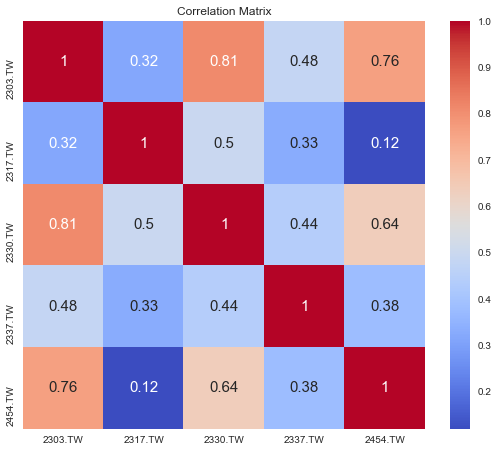

In [7]:
## 計算相關係數
import seaborn as sns

plt.figure(figsize=(9,7.5))
plt.title('Correlation Matrix')
sns.heatmap(close_df.corr(),annot=True,annot_kws={"size":15},cmap='coolwarm')
plt.show()

### 1.2 差分後相關係數

In [8]:
close_df.columns.to_list()

['2303.TW', '2317.TW', '2330.TW', '2337.TW', '2454.TW']

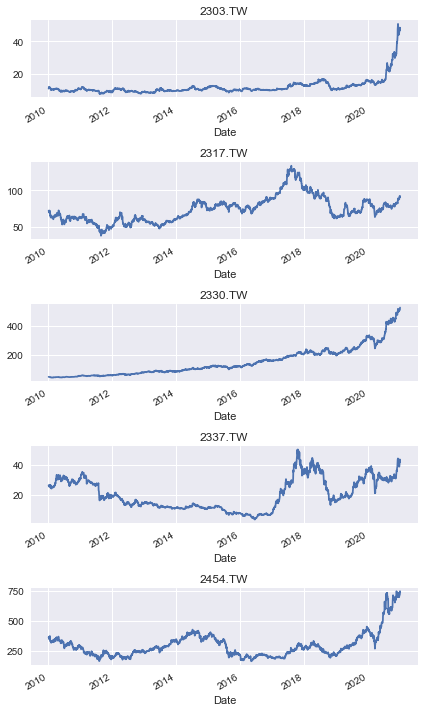

In [9]:
plt.figure(figsize=(6,10))
for col in close_df:
    plt.subplot(5,1,close_df.columns.to_list().index(col)+1)
    plt.title(col)
    close_df[col].plot()
plt.tight_layout()

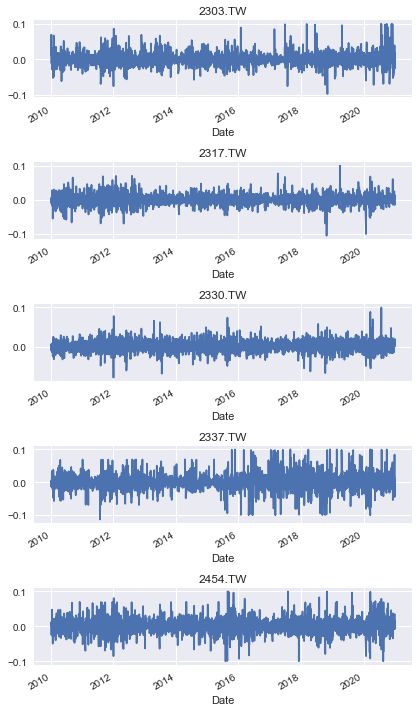

In [10]:
# 簡單報酬率（一階差分）
plt.figure(figsize=(6,10))
for col in close_df:
    plt.subplot(5,1,close_df.columns.to_list().index(col)+1)
    plt.title(col)
    close_df[col].pct_change(periods=1,fill_method="ffill").plot()
plt.tight_layout()

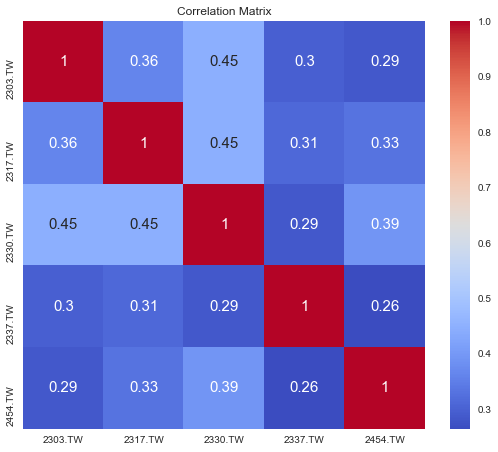

In [11]:
## 解決trend，做一階差分

plt.figure(figsize=(9,7.5))
plt.title('Correlation Matrix');
sns.heatmap(close_df.pct_change(periods=1,fill_method="ffill").corr(),annot=True,annot_kws={"size":15},cmap='coolwarm')
plt.show()

#### 目標：選取相關性最大的兩間公司做配對交易

In [12]:
# 用相關性最高的兩檔股票來做
stock_1='2303.TW'
stock_2='2330.TW'

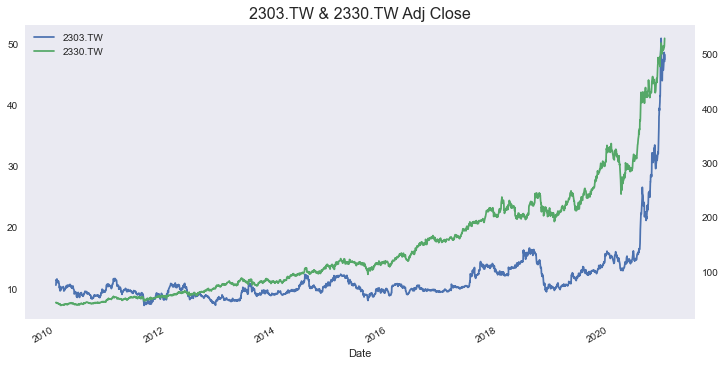

In [13]:
# 把兩張圖畫在一起 -> 熟悉繪圖方法！
plt.figure(figsize=(12,6))
plt.title('{} & {} Adj Close'.format(stock_1,stock_2),fontsize=16)

ax1 = close_df[stock_1].plot()
ax2 = close_df[stock_2].plot(secondary_y=True)

plt.grid()

lines = ax1.get_lines() + ax2.get_lines()
plt.legend(lines,[l.get_label() for l in lines])
plt.show()

### 1.3 計算價差比例（stock_2/stock_1 大的作為分子比較容易想像）
1. 看上面的圖，相除後大約是一個數值 -> 3.06 (example)
2. 因為我認為他們相關性很大，價差應該不會改變太多
3. 所以當價差過大時（比如說：超過兩個標準差），我認為會回歸到原本的價差
4. 價差比例太大 => stock_2 太大 => 做空stock_2，同時做多stock_1 => 直到價格恢復均衡
5. 價差比例太小 => stock_2 太小 => 做多stock_2，同時做空stock_1 => 直到價格恢復均衡
6. 因為長期的價差不準，所以我們用移動視窗取出過去一段期間價差的平均數與標準差
7. 有了價差的平均數與標準差，就可以用類似布林通道找出訊號

In [14]:
close_df[stock_2]/close_df[stock_1]

Date
2010-01-04     4.117808
2010-01-05     4.044842
2010-01-06     3.804496
2010-01-07     3.763461
2010-01-08     3.792966
                ...    
2020-12-25    10.930481
2020-12-28    10.596708
2020-12-29    10.864979
2020-12-30    10.869565
2020-12-31    11.240721
Length: 2702, dtype: float64

In [15]:
# 計算價差比例
Spread_Ratio = close_df[stock_2]/close_df[stock_1]

# 全部的平均、全部的標準差
# 但我在過去，怎麼可能知道未來計算出的平均價差呢ＸＤ
Spread_Ratio_Mean = Spread_Ratio.mean()
Spread_Ratio_Std = Spread_Ratio.std()

print("Spread_Ratio_Mean :",Spread_Ratio_Mean)
print("Spread_Ratio_Std:",Spread_Ratio_Std)

Spread_Ratio_Mean : 11.909029382573499
Spread_Ratio_Std: 5.25738655580719


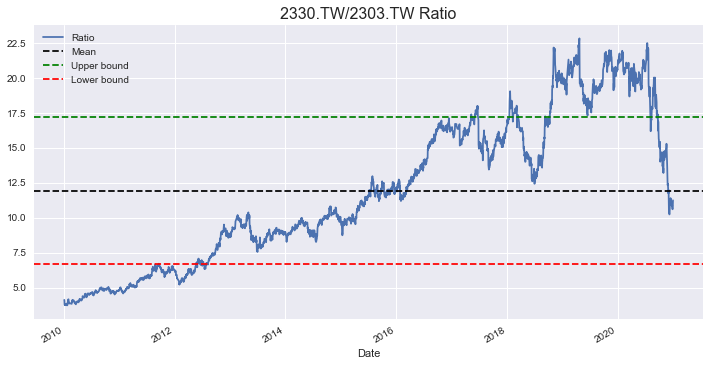

In [16]:
# 所以說下面這張圖當然就只能當作看看就好
# 大概知道有這個價差的關係，當超過時預期會回歸均衡

crit=1

plt.figure(figsize=(12,6))
plt.title('{}/{} Ratio'.format(stock_2,stock_1),fontsize=16)

Spread_Ratio.plot(label='Ratio')

plt.axhline(Spread_Ratio_Mean,label='Mean',ls='--',c='black')
plt.axhline(Spread_Ratio_Mean+crit*Spread_Ratio_Std,label='Upper bound',ls='--',c='g')
plt.axhline(Spread_Ratio_Mean-crit*Spread_Ratio_Std,label='Lower bound',ls='--',c='r');

plt.legend()

### 1.4 移動窗格價差比例

In [17]:
Spread_Ratio.rolling(5).sum()

Date
2010-01-04          NaN
2010-01-05          NaN
2010-01-06          NaN
2010-01-07          NaN
2010-01-08    19.523573
                ...    
2020-12-25    54.940118
2020-12-28    54.662221
2020-12-29    54.389345
2020-12-30    54.217695
2020-12-31    54.502454
Length: 2702, dtype: float64

In [18]:
Spread_Ratio.rolling(5).mean()

Date
2010-01-04          NaN
2010-01-05          NaN
2010-01-06          NaN
2010-01-07          NaN
2010-01-08     3.904715
                ...    
2020-12-25    10.988024
2020-12-28    10.932444
2020-12-29    10.877869
2020-12-30    10.843539
2020-12-31    10.900491
Length: 2702, dtype: float64

In [19]:
# 計算過去每六十天的價差平均與價差標準差
window = 60
crit = 1

Spread_Ratio_MA = Spread_Ratio.rolling(window=window).mean()
Spread_Ratio_rolling_Std = Spread_Ratio.rolling(window=window).std()
upper_bound = Spread_Ratio_MA+crit*Spread_Ratio_rolling_Std
lower_bound = Spread_Ratio_MA-crit*Spread_Ratio_rolling_Std

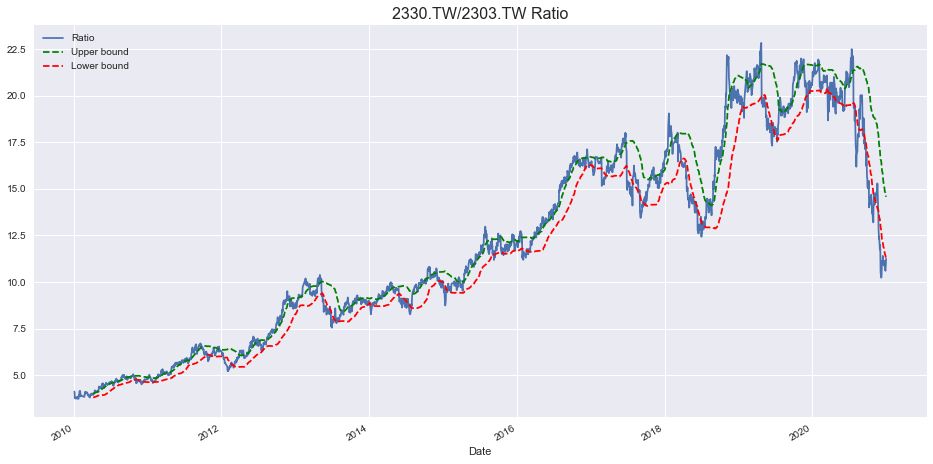

In [20]:
# 當下的價差比例跟過去六十天的價差比起來，會不會太大或太小
# 如果太大或太小，就可以同時做多做空進行套利
# 什麼時候平倉了結，也是一個需要探討的問題

plt.figure(figsize=(16,8))
plt.title('{}/{} Ratio'.format(stock_2,stock_1),fontsize=16)

Spread_Ratio.plot(label='Ratio')
#Spread_Ratio_MA.plot(label='Mean',ls='--',c='black')
upper_bound.plot(label='Upper bound',ls='--',c='g')
lower_bound.plot(label='Lower bound',ls='--',c='r')

plt.legend();

## 2. 回測
#### 複習一下價差套利：
1. 價差大於一個標準差 => 做空投資組合 => 做空stock2，做多stock1
2. 價差從大於一個標準差，回歸一個標準差內 => 平倉
3. 價差小於一個標準差 => 做多投資組合 => 做多stock2，做空stock1
4. 價差從小於一個標準差，回歸一個標準差內 => 平倉

> ##### 股票不能做空，而且同時買入和賣出的部位金額不能一樣多！
> ##### 限制太多了，因此我把它想像成期貨來計算好了
> ##### 這樣就可以假設做多和做空部位的金額一樣，再用個別漲跌幅計算損益

### 2.0 產出訊號
1. 穿過上通道時 => 做空投資組合 -1
2. 從上通道回歸均衡 => 平倉 (-1 -> 0)
3. 穿過下通道時 => 做多投資組合 1
4. 從下通道回歸均衡 => 平倉 (1 -> 0)
> ##### 產生訊號的下一期才做交易

In [21]:
# 建立交易訊號
# 建立一個list，當達成條件時append進-1與1

signal=[]
for i in range(len(Spread_Ratio)):
    if Spread_Ratio[i] > upper_bound[i]:
        signal.append(-1)
    elif Spread_Ratio[i] < lower_bound[i]:
        signal.append(1)
    else:
        signal.append(0)

<AxesSubplot:xlabel='Date'>

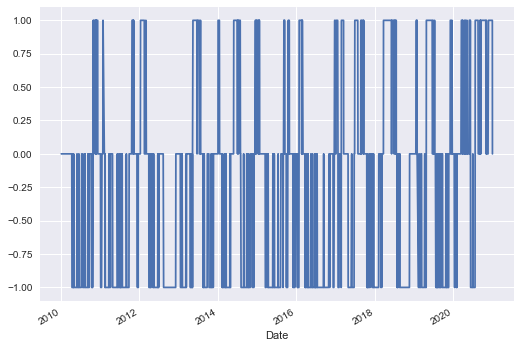

In [22]:
## 組成 series，看出建倉與平倉（0 就是已平倉）
signal_df=pd.Series(signal,index=Spread_Ratio.index)

plt.figure(figsize=(8.5,6))
signal_df.plot()

### 2.1 計算做空、做多損益

In [23]:
# 單期投資報酬率
# 5/7的報酬率：5/6~5/7收盤價的漲跌幅

long_stock1 = close_df[stock_1] / close_df[stock_1].shift(1)
long_stock1.fillna(1, inplace = True)

short_stock1 = close_df[stock_1].shift(1) / close_df[stock_1]
short_stock1.fillna(1, inplace = True)

long_stock2 = close_df[stock_2] / close_df[stock_2].shift(1)
long_stock2.fillna(1, inplace = True)

short_stock2 = close_df[stock_2].shift(1) / close_df[stock_2]
short_stock2.fillna(1, inplace = True);

In [24]:
# 總資金
wealth = 1000000.0

# 投資部位總表
portfolio = pd.DataFrame(index=Spread_Ratio.index)
portfolio['position_stock1'] = 0
portfolio['position_stock2'] = 0
portfolio['hold'] = 0
portfolio['wealth'] = 0
portfolio['signal'] = signal
portfolio['ret_long_stock1'] = long_stock1
portfolio['ret_short_stock1'] = short_stock1
portfolio['ret_long_stock2'] = long_stock2
portfolio['ret_short_stock2'] = short_stock2
portfolio.loc['2010-01-04', 'hold'] = wealth
portfolio.loc['2010-01-04', 'wealth'] = wealth
portfolio

,position_stock1,position_stock2,hold,wealth,signal,ret_long_stock1,ret_short_stock1,ret_long_stock2,ret_short_stock2
Date,,,,,,,,,
2010-01-04,0,0,1000000,1000000,0,1.000000,1.000000,1.000000,1.000000
2010-01-05,0,0,0,0,0,1.011765,0.988372,0.993836,1.006202
2010-01-06,0,0,0,0,0,1.069768,0.934783,1.006202,0.993836
2010-01-07,0,0,0,0,0,1.000000,1.000000,0.989214,1.010904
2010-01-08,0,0,0,0,0,0.989130,1.010989,0.996885,1.003125
...,...,...,...,...,...,...,...,...,...
2020-12-25,0,0,0,0,1,1.004296,0.995722,1.001961,0.998043
2020-12-28,0,0,0,0,1,1.039572,0.961934,1.007828,0.992233
2020-12-29,0,0,0,0,1,0.975309,1.025316,1.000000,1.000000


### 2.2 撰寫回測規則
#### 複習：
> ##### signal = 1 => 做多stock2, 做空stock1
> ##### signal = -1 => 做多stock1, 做空stock2

1. 通用規則：wealth = position_stock1 + position_stock2 + hold
2. 假如前一期signal = 0，這一期signal = 1 or -1；這一期的position_stock1 = 2/wealth，這一期的position_stock2 = 2/wealth，這一期的hold = 0；意即訊號下一期才開始投資
3. 假如前一期signal = 1，這一期signal = 1 or 0；這一期的position_stock1 = 前一期的position_stock1 * 這一期的ret_short_stock1，這一期的position_stock2 = 前一期的position_stock2 * 這一期的ret_long_stock2，這一期的hold = 前一期的hold
4. 假如前一期signal = -1，這一期signal = -1 or 0；這一期的position_stock1 = 前一期的position_stock1 * 這一期的ret_long_stock1，這一期的position_stock2 = 前一期的position_stock2 * 這一期的ret_short_stock2，這一期的hold = 前一期的hold
5. 假如前一期signal = 0，這一期signal = 0；這一期的position_stock1, position_stock2 = 0，這一期的hold 等於前一期的wealth

* 處理賦值警告：https://blog.csdn.net/haolexiao/article/details/81180571

In [25]:
# 忽略警告
# 記得賦值要用.loc .iloc 就好
pd.options.mode.chained_assignment = None

In [26]:
for i in range(1, len(portfolio)):
    if portfolio['signal'][i-1] == 0 and (portfolio['signal'][i] == 1 or portfolio['signal'][i] == -1):
        portfolio.loc[:,'position_stock1'].iloc[i] = portfolio.loc[:,'wealth'].iloc[i-1] / 2
        portfolio.loc[:,'position_stock2'].iloc[i] = portfolio.loc[:,'wealth'].iloc[i-1] / 2
        portfolio.loc[:,'hold'].iloc[i] = 0
    elif portfolio['signal'][i-1] == 1 and (portfolio['signal'][i] == 1 or portfolio['signal'][i] == 0):
        portfolio.loc[:,'position_stock1'].iloc[i] = portfolio.loc[:,'position_stock1'].iloc[i-1] * portfolio.loc[:,'ret_short_stock1'].iloc[i]
        portfolio.loc[:,'position_stock2'].iloc[i] = portfolio.loc[:,'position_stock2'].iloc[i-1] * portfolio.loc[:,'ret_long_stock2'].iloc[i]
        portfolio.loc[:,'hold'].iloc[i] = portfolio.loc[:,'hold'].iloc[i-1]
    elif portfolio['signal'][i-1] == -1 and (portfolio['signal'][i] == -1 or portfolio['signal'][i] == 0):
        portfolio.loc[:,'position_stock1'].iloc[i] = portfolio.loc[:,'position_stock1'].iloc[i-1] * portfolio.loc[:,'ret_long_stock1'].iloc[i]
        portfolio.loc[:,'position_stock2'].iloc[i] = portfolio.loc[:,'position_stock2'].iloc[i-1] * portfolio.loc[:,'ret_short_stock2'].iloc[i]
        portfolio.loc[:,'hold'].iloc[i] = portfolio.loc[:,'hold'].iloc[i-1]
    elif portfolio['signal'][i-1] == 0 and portfolio['signal'][i] == 0:
        portfolio.loc[:,'position_stock1'].iloc[i] = 0
        portfolio.loc[:,'position_stock2'].iloc[i] = 0
        portfolio.loc[:,'hold'].iloc[i] = portfolio.loc[:,'wealth'].iloc[i-1]
    portfolio.loc[:,'wealth'].iloc[i] = portfolio.loc[:,'position_stock1'].iloc[i] + portfolio.loc[:,'position_stock2'].iloc[i] + portfolio.loc[:,'hold'].iloc[i]
portfolio

,position_stock1,position_stock2,hold,wealth,signal,ret_long_stock1,ret_short_stock1,ret_long_stock2,ret_short_stock2
Date,,,,,,,,,
2010-01-04,0.000000,0.000000,1000000.0,1.000000e+06,0,1.000000,1.000000,1.000000,1.000000
2010-01-05,0.000000,0.000000,1000000.0,1.000000e+06,0,1.011765,0.988372,0.993836,1.006202
2010-01-06,0.000000,0.000000,1000000.0,1.000000e+06,0,1.069768,0.934783,1.006202,0.993836
2010-01-07,0.000000,0.000000,1000000.0,1.000000e+06,0,1.000000,1.000000,0.989214,1.010904
2010-01-08,0.000000,0.000000,1000000.0,1.000000e+06,0,0.989130,1.010989,0.996885,1.003125
...,...,...,...,...,...,...,...,...,...
2020-12-25,665325.143300,884990.429908,0.0,1.550316e+06,1,1.004296,0.995722,1.001961,0.998043
2020-12-28,639999.000532,891917.947950,0.0,1.531917e+06,1,1.039572,0.961934,1.007828,0.992233
2020-12-29,656201.465148,891917.947950,0.0,1.548119e+06,1,0.975309,1.025316,1.000000,1.000000


<AxesSubplot:xlabel='Date'>

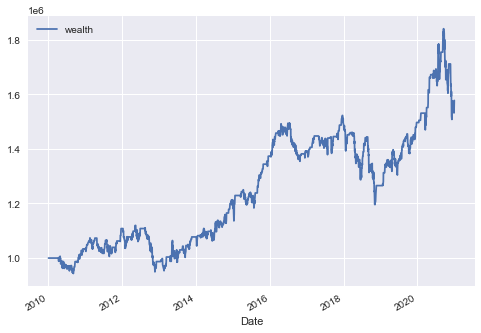

In [27]:
portfolio[['wealth']].plot()

### 2.3 損益比較
比較單獨持有和對沖持有的損益

In [28]:
def calculate_ret(df):
    ret = df / df.shift(1)
    ret.fillna(1, inplace = True)
    ret = ret.cumprod()
    ret = ret - 1
    return ret

In [29]:
a = calculate_ret(df = portfolio[['wealth']])
b = calculate_ret(close_df[[stock_1]])
c = calculate_ret(close_df[[stock_2]])

compare_ret = pd.concat([a,b,c], axis = 1)
compare_ret

,wealth,2303.TW,2330.TW
Date,,,
2010-01-04,0.000000,0.000000,0.000000
2010-01-05,0.000000,0.011765,-0.006164
2010-01-06,0.000000,0.082353,0.000000
2010-01-07,0.000000,0.082353,-0.010786
2010-01-08,0.000000,0.070588,-0.013867
...,...,...,...
2020-12-25,0.550316,3.391435,10.656808
2020-12-28,0.531917,3.565214,10.748055
2020-12-29,0.548119,3.452493,10.748055


是台積電和聯電太扯了啦，不是套利績效太差！
> #### 台積電累積報酬率 1109%
> #### 聯電累積報酬率 343%
> #### 價差套利累積報酬率 58%

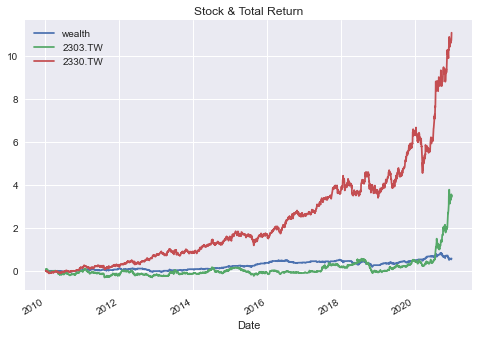

In [30]:
compare_ret.plot(label='Total Return', title = 'Stock & Total Return')
plt.legend();

### 2.4 績效指標與畫圖
* **每筆持有時間**
* **每筆報酬率**
* 交易次數（多/空）
* 正向/負向 分別計算交易次數、勝率、平均報酬率
* 交易勝率
* 每筆平均報酬
* 單筆最大報酬
* 單筆最大虧損
* 累積報酬率
* 年化報酬率
* 一年內最大回撤
* 年化標準差
* 年化負標準差
* Sharpe Ratio
* Sortino Ratio
* Calmar Ratio

In [31]:
# 陣列中的陣列－紀錄出手情形
trade_record = []

for i in range(1, len(portfolio)-1):
     
    if portfolio['signal'][i-1] == 0 and (portfolio['signal'][i] == 1 or portfolio['signal'][i] == -1):      
        
        # 開始記錄
        num = 1
        record = []
        
        #1 做多/做空投資組合
        if portfolio['signal'][i] == 1:
            record.append('long')
        if portfolio['signal'][i] == -1:
            record.append('short')
        
        record.append(portfolio.index[i]) #2 起始時間
        record.append(portfolio['wealth'][i]) #3 起始金額
        
    if (portfolio['signal'][i-1] == 1 or portfolio['signal'][i-1] == -1) and (portfolio['signal'][i] == 1 or portfolio['signal'][i] == -1):
        num += 1
        
    if (portfolio['signal'][i] == 1 or portfolio['signal'][i] == -1) and portfolio['signal'][i+1] == 0:
        record.append(portfolio.index[i]) #4 結束時間
        record.append(portfolio['wealth'][i]) #5 結束金額
        record.append(num) #6 持有時間
        
        # 記錄完成
        trade_record.append(record)
        
trade_record = pd.DataFrame(trade_record, columns = ['portfolio_position', 'start_time', 'start_wealth', 
                                                     'end_time', 'end_wealth', 'hold_time'])

In [32]:
trade_record['acc_return'] = (trade_record['end_wealth'] / trade_record['start_wealth']) - 1
trade_record['result'] = ['win' if i >= 0 else 'lose' for i in trade_record['acc_return']]
trade_record

,portfolio_position,start_time,start_wealth,end_time,end_wealth,hold_time,acc_return,result
0,short,2010-04-13,1.000000e+06,2010-04-23,9.976763e+05,9,-0.002324,lose
1,short,2010-04-27,1.001300e+06,2010-04-27,1.001300e+06,1,0.000000,win
2,short,2010-04-29,1.006682e+06,2010-05-28,9.768378e+05,22,-0.029646,lose
3,short,2010-06-01,9.871240e+05,2010-06-15,9.709274e+05,11,-0.016408,lose
4,short,2010-06-18,9.755136e+05,2010-07-09,9.662598e+05,16,-0.009486,lose
...,...,...,...,...,...,...,...,...
189,long,2020-09-07,1.754497e+06,2020-09-07,1.754497e+06,1,0.000000,win
190,long,2020-09-09,1.797642e+06,2020-09-09,1.797642e+06,1,0.000000,win
191,long,2020-09-15,1.827955e+06,2020-10-30,1.645359e+06,31,-0.099891,lose
192,long,2020-11-04,1.679261e+06,2020-11-04,1.679261e+06,1,0.000000,win


In [33]:
# 統整持有時間
trade_times = []
for i in portfolio.index:
    
    for j,k in zip(trade_record['start_time'], trade_record['end_time']):
    
        if i >= j and i <= k:
            trade_times.append(trade_record.set_index('start_time').loc[j]['hold_time'])
            break
            
        if j == trade_record['start_time'].iloc[-1]:
            trade_times.append(0)
            break
            
trade_times = pd.DataFrame(trade_times, index = portfolio.index)
trade_times.columns = ['hold_time']
trade_times

,hold_time
Date,
2010-01-04,0
2010-01-05,0
2010-01-06,0
2010-01-07,0
2010-01-08,0
...,...
2020-12-25,28
2020-12-28,28
2020-12-29,28


In [34]:
# 計算累積報酬與最大回撤
portfolio['portfolio_return'] = calculate_ret(portfolio['wealth'])
portfolio['portfolio_MDD'] = (portfolio['wealth'] / portfolio['wealth'].rolling(min_periods = 1, window = 240).max()) - 1
high_index = portfolio['portfolio_return'][portfolio['portfolio_return'].cummax() == portfolio['portfolio_return']].index

In [35]:
# 標準年化時間
day_of_year = len(close_df[stock_1].index) / 11
total_days = len(close_df[stock_1].index)
total_years = total_days / day_of_year

In [36]:
# 計算財務指標
Accumulation_return = portfolio['portfolio_return'][-1]
Annual_return = ((portfolio['wealth'][-1] / portfolio['wealth'][0]) ** (1/total_years)) - 1
Max_drawdown = abs(portfolio['portfolio_MDD'].min())
Annual_volatility = portfolio['wealth'].pct_change().dropna().std() * np.sqrt(day_of_year)
Neg_annual_volatility = portfolio[['wealth']].pct_change().dropna().applymap(lambda x: 0 if x > 0 else x).std()[0] * np.sqrt(day_of_year)
Sharpe_ratio = Annual_return / Annual_volatility
Sortino_ratio = Annual_return / Neg_annual_volatility
Calmar_ratio = Annual_return / Max_drawdown

In [37]:
# 計算交易情形
odds_of_win = len(trade_record.loc[trade_record['result'].isin(['win'])]) / len(trade_record)
max_ret_of_trade = trade_record['acc_return'].max()
min_ret_of_trade = trade_record['acc_return'].min()
mean_ret_of_trade = trade_record['acc_return'].mean()
max_holdtime_of_trade = trade_record['hold_time'].max()
min_holdtime_of_trade = trade_record['hold_time'].min()
mean_holdtime_of_trade = trade_record['hold_time'].mean()
time_of_trade = len(trade_record)
time_of_long_of_trade = len(trade_record.loc[trade_record['portfolio_position'].isin(['long'])])
time_of_short_of_trade = len(trade_record.loc[trade_record['portfolio_position'].isin(['short'])])

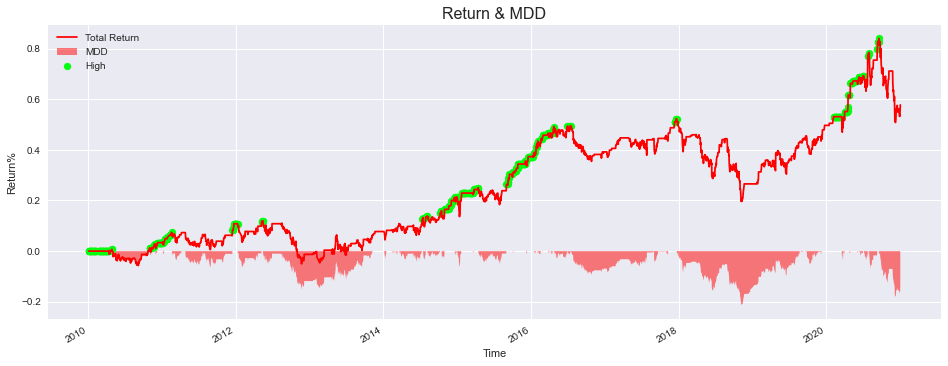

In [38]:
fig, ax = plt.subplots(figsize = (16,6))

portfolio['portfolio_return'].plot(label = 'Total Return', ax = ax, c = 'r')
plt.fill_between(portfolio['portfolio_MDD'].index, portfolio['portfolio_MDD'], 0, facecolor  = 'r', label = 'MDD', alpha=0.5)
plt.scatter(high_index, portfolio['portfolio_return'].loc[high_index],c = '#02ff0f', label = 'High')

plt.legend()
plt.ylabel('Return%')
plt.xlabel('Time')
plt.title('Return & MDD',fontsize  = 16);

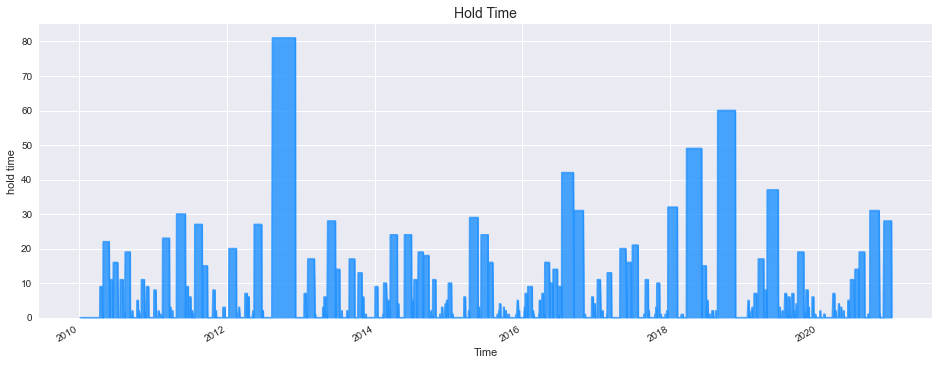

In [39]:
trade_times.plot.area(stacked=False, color = 'dodgerblue', alpha = 0.8, legend = False, figsize = (16,6))
plt.ylabel('hold time')
plt.xlabel('Time')
plt.title('Hold Time',fontsize  = 14);

In [40]:
# 數據結果
print('<財務指標>')
print('累積報酬率:', round(Accumulation_return, 4))
print('年化報酬率:', round(Annual_return, 4))
print('一年內最大回撤:', round(Max_drawdown, 4))
print('年化標準差:', round(Annual_volatility, 4))
print('年化負標準差:', round(Neg_annual_volatility, 4))
print('Sharpe Ratio:', round(Sharpe_ratio, 4))
print('Sortino Ratio:', round(Sortino_ratio, 4))
print('Calmar Ratio:', round(Calmar_ratio, 4))
print()
print('<交易情況>')
print('交易勝率:', round(odds_of_win, 4))
print('單筆最大報酬:', round(max_ret_of_trade, 4))
print('單筆最大虧損:', round(min_ret_of_trade, 4))
print('單筆平均報酬:', round(mean_ret_of_trade, 4))
print('單筆最大持有時間:', max_holdtime_of_trade)
print('單筆最小持有時間:', min_holdtime_of_trade)
print('單筆平均持有時間:', mean_holdtime_of_trade)
print('交易次數:', time_of_trade)
print('做多投資組合次數:', time_of_long_of_trade)
print('做空投資組合次數:', time_of_short_of_trade)

<財務指標>
累積報酬率: 0.5776
年化報酬率: 0.0423
一年內最大回撤: 0.2144
年化標準差: 0.1084
年化負標準差: 0.069
Sharpe Ratio: 0.3902
Sortino Ratio: 0.6136
Calmar Ratio: 0.1974

<交易情況>
交易勝率: 0.4845
單筆最大報酬: 0.0241
單筆最大虧損: -0.1308
單筆平均報酬: -0.0081
單筆最大持有時間: 81
單筆最小持有時間: 1
單筆平均持有時間: 8.072164948453608
交易次數: 194
做多投資組合次數: 62
做空投資組合次數: 132
